<img src="https://www.lsce.ipsl.fr/Css/img/banniere_LSCE_75.png" width="600px">

## Mapping DYNAMICO output with cartopy

- Author: Patrick Brockmann
- Version: 22/05/2024

In [1]:
import numpy as np
import xarray as xr

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
print(matplotlib.__version__)

3.8.3


In [3]:
import cartopy
import cartopy.crs as ccrs
print(cartopy.__version__)

0.23.0


### Open dataset

In [4]:
ds = xr.open_dataset("https://thredds-su.ipsl.fr/thredds/dodsC/ipsl_thredds/brocksce/ICO/ICO.79.1jour.native.1_19790101_19790101_1D_inca_ges.nc")
ds

<xarray.Dataset> Size: 3GB
Dimensions:               (cell: 16002, nvertex: 6, presnivs: 79,
                           time_counter: 24, axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 64kB ...
    lon                   (cell) float32 64kB ...
  * presnivs              (presnivs) float32 316B 1.012e+05 1.009e+05 ... 1.483
    time_centered         (time_counter) datetime64[ns] 192B ...
  * time_counter          (time_counter) datetime64[ns] 192B 1979-01-01T00:30...
    time_instant          (time_counter) datetime64[ns] 192B ...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables: (12/29)
    bounds_lon            (cell, nvertex) float32 384kB ...
    bounds_lat            (cell, nvertex) float32 384kB ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 384B ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 384B ...
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] 384B ...
    pmid                  (time_counter, presnivs, cell) float64 243MB ...
    ...                    ...
    vmrmcf                (time_counter, presnivs, cell) float64 243MB ...
    vmrbe7                (time_counter, presnivs, cell) float64 243MB ...
    vmrn2o                (time_counter, presnivs, cell) float64 243MB ...
    vmrch4                (time_counter, presnivs, cell) float64 243MB ...
    vmrco                 (time_counter, presnivs, cell) float64 243MB ...
    vmrco2bih             (time_counter, presnivs, cell) float64 243MB ...
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.0|hdf5lib...
    name:                            inca1d_ges
    description:                     Created by xios
    title:                           Created by xios
    Conventions:                     CF-1.6
    timeStamp:                       2022-Apr-05 08:59:15 GMT
    uuid:                            8982bdb7-b650-45c4-896c-e228bec0cb5a
    history:                         Fri Apr 15 12:05:37 2022: ncatted -O -a ...
    NCO:                             4.6.9
    DODS_EXTRA.Unlimited_Dimension:  time_counter

In [5]:
clon = ds['lon'].to_numpy()
blon = ds['bounds_lon'].to_numpy()
blat = ds['bounds_lat'].to_numpy()

nvertex = blon.shape[-1]
cell = blon.shape[0]
print(nvertex, cell)

6 16002


In [6]:
# From mapper https://github.com/PBrockmann/VTK_Mapper
# needed to limit excursion from center of the cell to longitude boundaries
def limit_lon(blon,clon):
    clon=(clon+360*10)%360
    clon=np.where(np.greater(clon,180),clon-360,clon)
    clon=np.where(np.less(clon,-180),clon+360,clon)
    clon1=np.ones(blon.shape,np.float32)*clon[...,None]

    blon=(blon+360*10)%360
    blon=np.where(np.greater(blon,180),blon-360,blon)
    blon=np.where(np.less(blon,-180),blon+360,blon)
    
    blon=np.where(np.greater(abs(blon-clon1),abs(blon+360-clon1)),blon+360,blon)
    blon=np.where(np.greater(abs(blon-clon1),abs(blon-360-clon1)),blon-360,blon)
    return blon

In [7]:
blon2 = limit_lon(blon, clon)
blon2

array([[ 3.5999756e+01,  5.3446045e+01,  5.7791016e+01,  3.5999512e+01,
         1.4208252e+01,  1.8553467e+01],
       [ 4.6505371e+01,  5.9614014e+01,  6.3306885e+01,  5.3446045e+01,
         3.5999756e+01,  3.6000000e+01],
       [ 5.2415283e+01,  6.2709961e+01,  6.5760254e+01,  5.9614014e+01,
         4.6505371e+01,  4.5388672e+01],
       ...,
       [ 3.6000000e+01,  3.5065430e+01,  3.5417480e+01,  3.6582764e+01,
         3.6934570e+01,  3.6000000e+01],
       [ 3.5999023e+01, -2.5199976e+02, -1.7999878e+02, -1.0799951e+02,
        -1.0799951e+02, -3.6000732e+01],
       [-2.8799902e+02, -2.4414062e-04, -7.2001221e+01, -1.4400049e+02,
        -1.4400049e+02, -2.1599902e+02]], dtype=float32)

In [8]:
loPoly = [list(zip(blon2[i], blat[i])) for i in range(cell)]

### Map with continuous levels

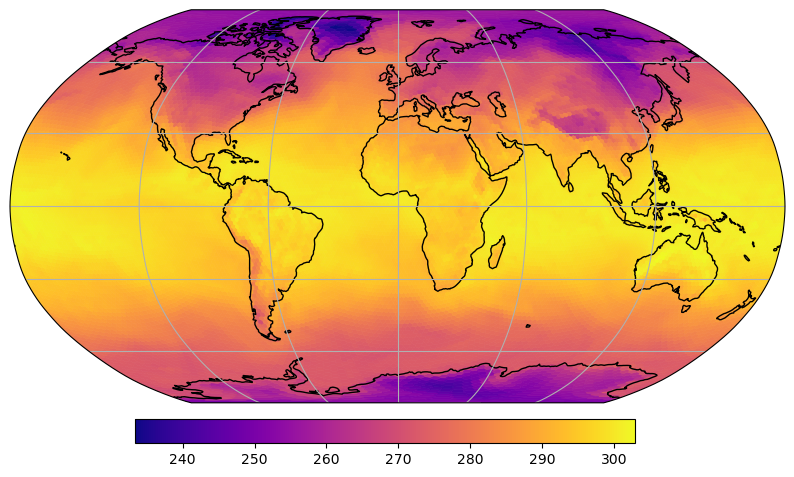

In [9]:
fig = plt.figure(clear=True, frameon=False, figsize=(10,6))

ax1 = plt.subplot(111, projection=ccrs.Robinson(central_longitude=0))

var = ds['temp'][0, 0]

varmin = np.min(var.values)
varmax = np.max(var.values)

cmap = plt.get_cmap('plasma')       # add '_r' for reverse
poly1 = PolyCollection(loPoly, transform=ccrs.PlateCarree(), cmap=cmap, clim=(varmin,varmax), 
                       edgecolor='face', lw=0.5)

poly1.set_array(var)
coll1 = ax1.add_collection(poly1)

cax = fig.add_axes([0.25, 0.1, 0.5, 0.04])  # (left, bottom, width, height)
cb = plt.colorbar(coll1, cax=cax, orientation='horizontal')

ax1.set_global()
ax1.coastlines()
ax1.gridlines()

plt.show()

### Map with discrete levels

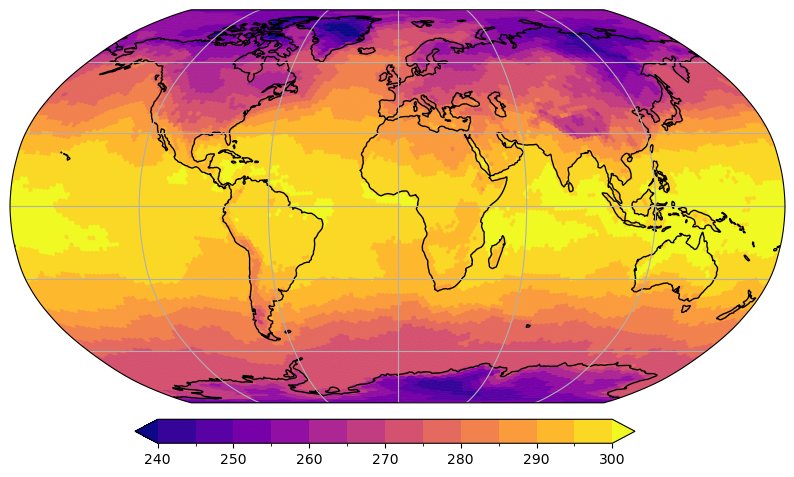

In [10]:
fig = plt.figure(clear=True, frameon=False, figsize=(10,6))

ax1 = plt.subplot(111, projection=ccrs.Robinson(central_longitude=0))

var = ds['temp'][0, 0]

varmin = np.min(var.values)
varmax = np.max(var.values)

levels = np.arange(240,305,5)
cmap = plt.get_cmap('plasma')       # add '_r' for reverse
colors = cmap(np.linspace(0, 1, len(levels)+1))
cmap, norm = matplotlib.colors.from_levels_and_colors(levels, colors, extend='both')

poly1 = PolyCollection(loPoly, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, 
                       edgecolor='face', lw=0.5)

poly1.set_array(var)
coll1 = ax1.add_collection(poly1)

cax = fig.add_axes([0.25, 0.1, 0.5, 0.04])  # (left, bottom, width, height)
cb = plt.colorbar(coll1, cax=cax, orientation='horizontal')

ax1.set_global()
ax1.coastlines()
ax1.gridlines()

plt.show()

### Add widgets for more interactivity

In [11]:
print(set(ds.dims))
print(set(ds.coords))
# Coordinates variables (variable name = dimension name) indicated by a * in xarray.Dataset
print(list(set(ds.dims) & set(ds.coords)))

{'cell', 'nvertex', 'axis_nbounds', 'time_counter', 'presnivs'}
{'time_instant', 'lon', 'time_counter', 'lat', 'time_centered', 'presnivs'}
['presnivs', 'time_counter']


In [12]:
# Could be detected automatically
dimK = 'presnivs'
dimL = 'time_counter'

In [13]:
kmax = ds[dimK].shape[0]
lmax = ds[dimL].shape[0]
print(kmax, lmax)

79 24


In [14]:
ds.data_vars

Data variables:
    bounds_lon            (cell, nvertex) float32 384kB 36.0 53.45 ... 144.0
    bounds_lat            (cell, nvertex) float32 384kB 86.6 87.07 ... -89.12
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 384B ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] 384B ...
    time_instant_bounds   (time_counter, axis_nbounds) datetime64[ns] 384B ...
    pmid                  (time_counter, presnivs, cell) float64 243MB ...
    sh                    (time_counter, presnivs, cell) float64 243MB ...
    pdel                  (time_counter, presnivs, cell) float64 243MB ...
    zdens                 (time_counter, presnivs, cell) float64 243MB ...
    temp                  (time_counter, presnivs, cell) float64 243MB ...
    AIRMASS               (time_counter, presnivs, cell) float64 243MB ...
    ps                    (time_counter, cell) float64 3MB ...
    area                  (time_counter, cell) float64 3MB ...
    emirn222    

In [15]:
def get_vars():
    vars = {}
    for var in ds.data_vars:
        dims = list(ds[var].dims)
        if dims[-1] == 'cell':
            dims.pop(-1)
            ndims = [d.replace(dimL, 'L').replace(dimK, 'K') for d in dims]
            vars[var] = {'dims': ''.join(ndims)}
    return vars

def get_title():
    try:
        title = ds[variable].name + ' (' + ds[variable].long_name + ')'
    except:
        title = ds[variable].name
    return title

def get_units():
    try:
        units = ds[variable].units
    except:
        units = ''
    return units + '\n'

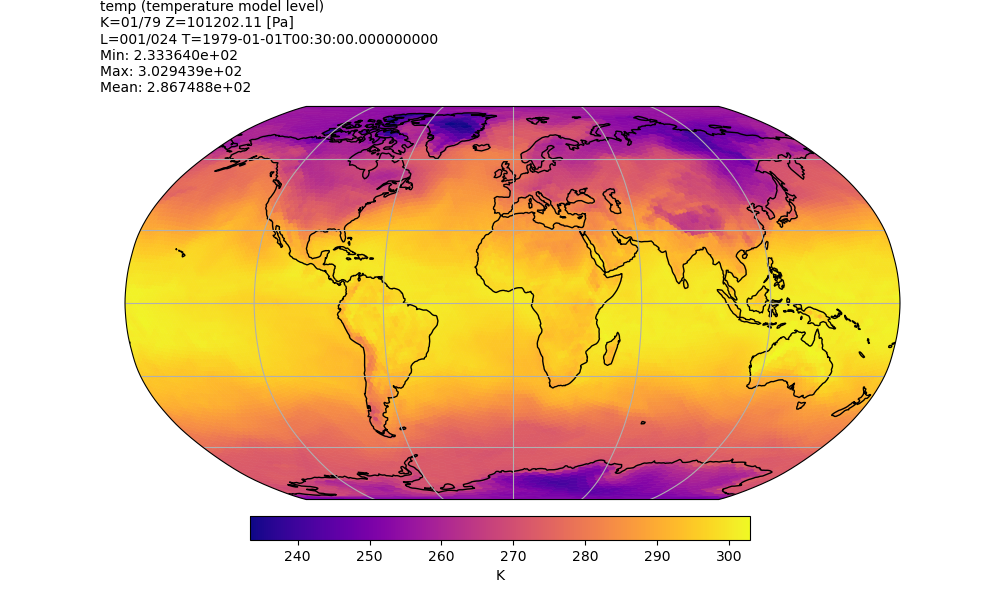

In [16]:
import matplotlib.pyplot as plt
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox

#==================================
variable = 'temp'
kindex = 1
lindex = 1
var_info = ""

vars = get_vars()
cmap = 'plasma'
auto_range = True

widget_edges = widgets.Checkbox(value=False, description='Edges')
widget_k = widgets.IntSlider(min=1, max=kmax, step=1, description='K :')
widget_l = widgets.IntSlider(min=1, max=lmax, step=1, description='L :')
widget_range = widgets.Checkbox(value=auto_range, description='Range update')
widget_cmap = widgets.Dropdown(options=matplotlib.colormaps(), value=cmap, description='cmap :')
widget_var = widgets.Dropdown(options=sorted(vars.keys()), value=variable, description='variable :')

#==================================
def load_var():
    global var, var_info
    if vars[variable]['dims'] == 'LK':
        widget_k.disabled = False
        widget_l.disabled = False
        var = ds[variable][lindex-1, kindex-1]
        try:
            zlevels_units = '[' + ds['presnivs'].units + ']'
        except:
            zlevels_units = ''
        var_info = "K=%02d/%02d Z=%s %s" %(kindex, kmax, ds['presnivs'][kindex-1].values, zlevels_units)
        var_info += "\nL=%03d/%03d T=%s" %(lindex, lmax, ds['time_counter'][lindex-1].values)
    elif vars[variable]['dims'] == 'L':
        widget_k.disabled = True
        widget_l.disabled = False
        var = ds[variable][lindex-1]
        var_info = "L=%03d/%03d T=%s" %(lindex, lmax, ds['time_counter'][lindex-1].values)
    elif vars[variable]['dims'] == 'K':
        widget_k.disabled = False
        widget_l.disabled = True
        var = ds[variable][kindex-1]
        try:
            zlevels_units = '[' + ds['presnivs'].units + ']'
        except:
            zlevels_units = ''
        var_info = "K=%03d/%03d Z=%s %s" %(kindex, kmax, ds['presnivs'][kindex-1].values, zlevels_units)     
    elif vars[variable]['dims'] == '':
        widget_k.disabled = True
        widget_l.disabled = True
        var = ds[variable]
        var_info = ""
    varmin = np.min(var.values)
    varmax = np.max(var.values)
    varmean = np.mean(var.values)
    stat_text = "Min: %e\nMax: %e\nMean: %e" %(varmin, varmax, varmean)
    var_info = var_info + '\n' + stat_text
    
    return var

var = load_var()

#==================================
varmin = np.min(var.values)
varmax = np.max(var.values)
cmap_name = 'plasma'
cmap = plt.get_cmap(cmap_name)

#==================================
fig = plt.figure(clear=True, frameon=False, figsize=(10,6))                      
#ax1 = plt.subplot(111, projection=ccrs.Mollweide(central_longitude=0))
ax1 = plt.subplot(111, projection=ccrs.Robinson(central_longitude=0))
poly1 = PolyCollection(loPoly, transform=ccrs.PlateCarree(), cmap=cmap, clim=(varmin,varmax), edgecolor='face', lw=0.5)
poly1.set_array(var)
coll1 = ax1.add_collection(poly1)
ax1.set_global()
ax1.coastlines()
ax1.gridlines()

#==================================
fig.subplots_adjust(wspace=0.02, hspace=0.02)
cax = fig.add_axes([0.25, 0.1, 0.5, 0.04])  # (left, bottom, width, height)
cb = plt.colorbar(coll1, cax=cax, orientation='horizontal')
cb.set_label(get_units())

#==================================
textA = plt.figtext(0.1, 1.0, get_title() + '\n' + var_info, 
                    verticalalignment='top', horizontalalignment='left', fontdict={'fontsize': 10})

#==================================
def on_edges_change(e):
    if e.new: 
        color = 'black'
        lw = 0.2
    else: 
        color='face'
        lw = 0.5
    poly1.set_linewidth(lw)
    poly1.set_edgecolor(color)
    plt.show()

#==================================
def on_kvalue_change(e):
    global kindex, var
    kindex = e.new
    var = load_var()
    poly1.set_array(var)
    textA.set_text(get_title() + '\n' + var_info)
    if auto_range: on_range_change(e)
    else: plt.show()

#==================================
def on_lvalue_change(e):
    global lindex, var
    lindex = e.new
    var = load_var()
    poly1.set_array(var)
    textA.set_text(get_title() + '\n' + var_info)
    if auto_range: on_range_change(e)
    else: plt.show()

#==================================
def on_range_change(e):
    global auto_range
    auto_range = e.new
    varmin = np.min(var.values)
    varmax = np.max(var.values)
    poly1.set_clim((varmin, varmax))
    coll1.set_clim((varmin, varmax))   # needed but why
    plt.show()

#==================================
def on_var_change(e):
    global variable, var
    variable = e.new
    var = load_var()
    poly1.set_array(var)
    textA.set_text(get_title() + '\n' + var_info)
    cb.set_label(get_units())
    if auto_range: on_range_change(e)
    else: plt.show()
        
#==================================
def on_cmap_change(e):
    global cmap_name
    cmap_name = e.new
    cmap = plt.get_cmap(cmap_name)
    poly1.set_cmap(cmap)
    plt.show()

#==================================
widget_var.observe(on_var_change, 'value')
widget_cmap.observe(on_cmap_change, 'value')
widget_k.observe(on_kvalue_change, 'value')
widget_l.observe(on_lvalue_change, 'value')
widget_range.observe(on_range_change, 'value')
widget_edges.observe(on_edges_change, 'value')

display( widgets.HBox([widgets.VBox([widget_var, widget_cmap]),
                       widgets.VBox([widget_k, widget_l]), 
                       widgets.VBox([widget_range, widget_edges])
                      ]) )

plt.show()